# Analyze Initial String

With this notebook you will be able to see if the initial string obtained from steering simulations (or the configurations you got some other way) are following the `string0.txt`. You will also be able to visualize the structures of the beads and compare them to the starting and final configurations.

In [1]:
import glob
import re
import MDAnalysis as mda
import matplotlib.pyplot as plt
import pickle
import numpy as np
from math import ceil
import nglview as nv
import os


def natural_sort(l):
    """
    Takes as input a list l of strings and sorts it with natural order.
      Parameters
      ----------
      l: list of strings.
      Returns
      -------
      l sorted
    """
    assert isinstance(l, list), "l is not a list!"
    for i in l:
        assert isinstance(i, str), "List contains non-string elements."
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [2]:
def distance_atom_groups(u, sel1, sel2, progressbar=True, center_of_mass=False):
    """
    Calculate the distance between the centers of geometry (or mass) between two groups (sel1, sel2) as a function of time in the trajectory trj.

    Parameters
    ----------
    u: MDA universe to analyz trajectory to analyze.
    sel1: MDA selection containing at least 1 atom.
    sel2: MDA selection containing at least 1 atom.
    center_of_mass: Use the center of mass instead of center of geometry.
    progressbar: Show progressbar.

    Returns
    -------
    d: matplotlib figure object.
    """
    from MDAnalysis import Universe
    from MDAnalysis import AtomGroup
    from numpy import array
    from tqdm import tqdm
    from numpy.linalg import norm

    assert isinstance(u, Universe), "u should be a MDAnlaysis universe."
    assert isinstance(sel1, AtomGroup), "sel1 should be a MDAnlaysis universe."
    assert isinstance(sel2, AtomGroup), "sel2 should be a MDAnlaysis universe."
    assert isinstance(progressbar, bool), "progressbar should be boolean."
    assert sel1.n_atoms >= 1, "sel1 should have at least 1 atom."
    assert sel2.n_atoms >= 1, "sel2 should have at least 1 atom."

    d = []
    for i, ts in tqdm(
        enumerate(u.trajectory), total=u.trajectory.n_frames, disable=not progressbar
    ):
        if center_of_mass:
            csel1 = sel1.center_of_mass()
            csel2 = sel2.center_of_mass()
        else:
            csel1 = sel1.centroid()
            csel2 = sel2.centroid()
        d.append([ts.dt * i, norm(csel1 - csel2)])
    return array(d)

Choose working directory

In the cell bellow you can select which will be the simulation directory (in case this notebook is elsewhere). If the notebook is in the simulation directory just leave it as ".".

In [3]:
simulation_directory = "."
os.chdir(simulation_directory)
os.getcwd()

'/data2/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV'

Read in the bead paths and cv variables.

In [4]:
beads = natural_sort(glob.glob("md/0/*/restrained"))

In [5]:
cvs, ndx_groups = pickle.load(open("cv.pkl", "rb"))

Calculate the values of the CVs in the `md/0/*/restrained/confout.gro` files.

In [8]:
topology = None  # 'topology/top.pdb'
dis = []

for b in beads[:]:

    if topology != None:
        u = mda.Universe(topology, b + "/confout.gro")
    else:
        u = mda.Universe(b + "/confout.gro")
    d = []
    for cv in cvs:
        d.append(
            distance_atom_groups(
                u,
                u.select_atoms(ndx_groups[list(ndx_groups.keys())[cv[0] - 1]]),
                u.select_atoms(ndx_groups[list(ndx_groups.keys())[cv[1] - 1]]),
                progressbar=False,
            center_of_mass=True)[-1, 1]
        )
    dis.append(np.array(d))
dis = np.array(dis) / 10

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:675: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` he

## Plot of `string0.txt` versus the configs that will be used.

The value of the cvs in the `confout.gro` should approximatelly follow `string0.txt`. If it doesn't you can increase the steering `kappa` and also make the steering simulation longer by increasing the `nsteps` per bead.

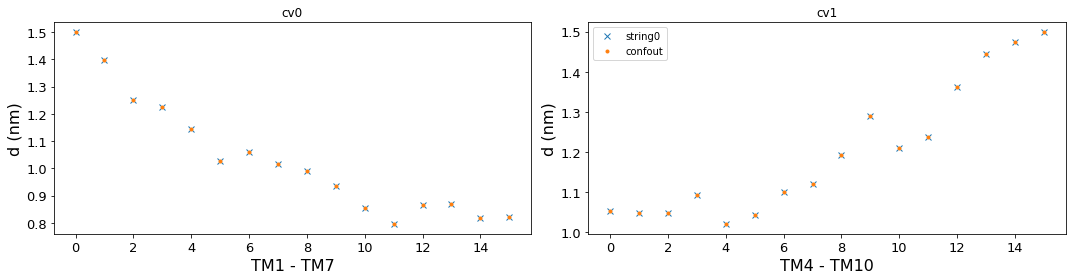

In [9]:
string = np.loadtxt("strings/string0.txt")
n_plots = string.shape[1]
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(15, 4 * ceil(n_plots / 2)))
ax = ax.flatten()
for i in range(n_plots):
    ax[i].plot(string[:, i], ls="", marker="x", label="string0")
    ax[i].set_xlabel(
        f"{list(ndx_groups.keys())[2*i]} - {list(ndx_groups.keys())[2*i+1]}", size=16
    )
    ax[i].set_ylabel("d (nm)", size=16)
    ax[i].tick_params(axis="both", which="major", labelsize=13)
if len(dis) != 0:
    for i in range(n_plots):
        ax[i].plot(dis[:, i], ls="", marker=".", label="confout")
        ax[i].set_title(f"cv{i}")
ax[1].legend()
if n_plots % 2:
    fig.delaxes(ax[-1])
fig.tight_layout()

## Visualize `confout.gro` with NGLview

If you have been able to install correctly [NGLview](https://github.com/nglviewer/nglview) in this jupyter-lab, which is tricky sometimes, you can visualize the `md/0/*/restrained/confout.gro` (in ribbon, green) files and compare it to `start.gro` (blue, rope) and `end.gro` (red, rope).

In [ ]:
from MDAnalysis.analysis.align import AlignTraj

In [ ]:
traj = mda.Universe(
    beads[0] + "/confout.gro", [b + "/confout.gro" for b in beads], in_memory=True
)
start = mda.Universe("topology/start.gro")
end = mda.Universe("topology/end.gro")
AlignTraj(traj, start, select="name CA and protein", in_memory=True).run()
AlignTraj(end, start, select="name CA and protein", in_memory=True).run()

In [ ]:
view = nv.show_mdanalysis(traj, default=False)
view.add_trajectory(start, default=False)
view.add_trajectory(end, default=False)
view.add_ribbon(selection="protein", color="green", component=0)
view.add_rope(selection="protein", color="blue", component=1)
view.add_rope(selection="protein", color="red", component=2)
view.center()

Sometimes need to run this cell several times to see something. Sometimes it takes a few seconds to load.

In [ ]:
view